# Neural Networks



<a id="subsection-modules"></a>
### Import useful modules

We begin by importing the classic modules for machine learning.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

<a id="subsection-exploration"></a>
### Data exploration 

The first step is to explore the data, and see what is inside.

In [2]:
data = pd.read_csv("/kaggle/input/mobile-price-classification/train.csv", dtype=np.float64)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   float64
 1   blue           2000 non-null   float64
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   float64
 4   fc             2000 non-null   float64
 5   four_g         2000 non-null   float64
 6   int_memory     2000 non-null   float64
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   float64
 9   n_cores        2000 non-null   float64
 10  pc             2000 non-null   float64
 11  px_height      2000 non-null   float64
 12  px_width       2000 non-null   float64
 13  ram            2000 non-null   float64
 14  sc_h           2000 non-null   float64
 15  sc_w           2000 non-null   float64
 16  talk_time      2000 non-null   float64
 17  three_g        2000 non-null   float64
 18  touch_sc

In [3]:
print("We have:")
print(f"\t- {len(data)} available sales of smartphone")
print(f"\t- {len(data.columns)-1} features per smartphone.")
print(f"\t- Some of the features are {np.array(data.columns)[[0, 2, 13, 19]]}")
print(f"\t- the price ranges are {sorted(data.iloc[:, -1].unique())}")

We have:
	- 2000 available sales of smartphone
	- 20 features per smartphone.
	- Some of the features are ['battery_power' 'clock_speed' 'ram' 'wifi']
	- the price ranges are [0.0, 1.0, 2.0, 3.0]


<a id="subsection-normalization"></a>
### Data Normalization

The next step is to normalize the data: we want each features to have the same weights.
We also divide our data in 2 subsets: the training set and the validation set.

In [4]:
scaler = MinMaxScaler()
scaler.fit(data.iloc[:, :-1])
normalized_data = np.copy(data)
normalized_data[:, :-1] = scaler.transform(data.iloc[:, :-1])

train_data, validation_data = train_test_split(
    normalized_data,
    train_size=0.7,
    shuffle=True,
)

in_features = train_data.shape[1] - 1
out_classes = len(np.unique(train_data[:, -1]))

<a id="subsection-definition"></a>
### Network Definition

We then create our network:
* the first layer contains 20 nodes: 1 node for each feature
* then we define an arbitrary number of hidden layers with as much nodes as we want. Here we have
  * a second layer with 2048 nodes
  * a third layer with 4096 nodes
* the output layer contains 4 node: 1 node for each price range.

In between these layers, we have non linear functions. Here we took the Relu.

In [14]:
class NNNetwork(nn.Module):
    def __init__(self, in_features=20, out_classes=4):
        super().__init__()
        self.in_features = in_features
        self.out_classes = out_classes
        
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=4096, out_features=self.out_classes)
        )
        
    def forward(self, x):
        x = self.linear_layers(x)
        return x

<a id="subsection-training"></a>
### Training

We then define several objects:
* the datasets. Pytorch needs datasets as input. Basically a dataset is like a numpy array where operations are much quicker.
* the loss. For a classification problem, we are using the cross entropy loss.
* the optimizer. It is a tool that computes the loss minimum


In [15]:
train_dataset = TensorDataset(torch.FloatTensor(train_data[:, :-1]), torch.LongTensor(train_data[:, -1]))
validation_dataset = TensorDataset(torch.FloatTensor(validation_data[:, :-1]), torch.LongTensor(validation_data[:, -1]))

model = NNNetwork(in_features=in_features, out_classes=out_classes)

loss = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, 
                      weight_decay=0.0005)

In [16]:
def train(train_dataset, validation_dataset, model, criterion, optimizer, nb_epochs, batch_size):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=0)
    history_loss = []
    history_val_loss = []
    history_accuracy = []
    history_val_accuracy = []
    for epoch in range(nb_epochs):  # loop over the dataset multiple times
        print(f"epoch: {epoch+1}")
        model.train()
        train_loss = 0
        train_accuracy = 0
        for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() / len(train_dataset)
            train_accuracy += np.sum(np.argmax(outputs.detach().numpy(), axis=1) == labels.detach().numpy()) / len(train_dataset)

        model.eval()
        val_loss = 0
        val_accuracy = 0
        for data, labels in validation_dataloader:
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item() / len(validation_dataset)
            val_accuracy += np.sum(np.argmax(outputs.detach().numpy(), axis=1) == labels.detach().numpy()) / len(validation_dataset)
        
        print("{:<13}{:<30}{:<10}{:<30}".format("train loss", train_loss, "val loss", val_loss))
        print("{:<13}{:<30.3%}{:<10}{:<30.3%}".format("train acc", train_accuracy, "val acc", val_accuracy))

        history_val_loss.append(val_loss / len(validation_dataloader))
        history_loss.append(train_loss / len(train_dataloader) )

        history_accuracy.append(train_accuracy)
        history_val_accuracy.append(val_accuracy)
    
    return history_loss, history_val_loss, history_accuracy, history_val_accuracy

In [18]:
epochs = 10
batch_size = 64
history_loss, history_val_loss, history_accuracy, history_val_accuracy = train(train_dataset, validation_dataset, model, loss, optimizer, epochs, batch_size)

epoch: 1


100%|██████████| 22/22 [00:02<00:00, 10.21it/s]


train loss   0.004281931455646242          val loss  0.005337567279736202          
train acc    91.500%                       val acc   88.167%                       
epoch: 2


100%|██████████| 22/22 [00:02<00:00,  9.95it/s]


train loss   0.003617243117519787          val loss  0.004544195731480917          
train acc    94.857%                       val acc   91.333%                       
epoch: 3


100%|██████████| 22/22 [00:02<00:00, 10.08it/s]


train loss   0.003510928611670222          val loss  0.004462628811597825          
train acc    93.714%                       val acc   91.000%                       
epoch: 4


100%|██████████| 22/22 [00:02<00:00,  9.98it/s]


train loss   0.0033382555842399594         val loss  0.004288001482685407          
train acc    94.286%                       val acc   92.000%                       
epoch: 5


100%|██████████| 22/22 [00:02<00:00, 10.07it/s]


train loss   0.0029679496160575324         val loss  0.003900227745374044          
train acc    95.429%                       val acc   91.500%                       
epoch: 6


100%|██████████| 22/22 [00:02<00:00, 10.11it/s]


train loss   0.0028294041380286213         val loss  0.0038652663926283517         
train acc    95.571%                       val acc   91.833%                       
epoch: 7


100%|██████████| 22/22 [00:02<00:00, 10.25it/s]


train loss   0.002677903792687825          val loss  0.0036667209615310037         
train acc    95.286%                       val acc   91.667%                       
epoch: 8


100%|██████████| 22/22 [00:02<00:00, 10.07it/s]


train loss   0.00261217756995133           val loss  0.0035813910265763598         
train acc    95.571%                       val acc   92.500%                       
epoch: 9


100%|██████████| 22/22 [00:02<00:00,  8.70it/s]


train loss   0.0023071593152625223         val loss  0.003502843628327052          
train acc    96.357%                       val acc   92.000%                       
epoch: 10


100%|██████████| 22/22 [00:02<00:00, 10.14it/s]


train loss   0.0025352830120495395         val loss  0.003358973873158296          
train acc    95.000%                       val acc   92.500%                       


<a id="subsection-metrics"></a>
### Metrics

The last step is to get metrics from our training. 

Victory !!

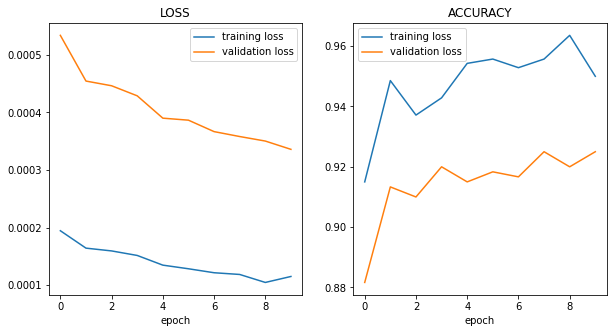

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(history_loss, label="training loss")
axs[0].plot(history_val_loss, label="validation loss")
axs[0].legend()
axs[0].set_title("LOSS")
axs[0].set_xlabel("epoch")

axs[1].plot(history_accuracy, label="training loss")
axs[1].plot(history_val_accuracy, label="validation loss")
axs[1].legend()
axs[1].set_title("ACCURACY")
axs[1].set_xlabel("epoch")
plt.show()

<a id="section-two"></a>
## Second problem

In this problem, an input is a 2D point. Each 2D point is then associated to a class. 
As before, we have features which are the coordinates of the points, and their class, computed through an unknown mapping.

In [21]:
def unknown_mapping(features, out_classes):
    return np.sum(np.mod(3*features, out_classes).astype(int), axis=1) % out_classes

out_classes = 4
features = np.random.uniform(size=(20000, 2))
labels = unknown_mapping(features, out_classes)

<a id="subsection-exploration2"></a>
### Data exploration

Once again, we explore the data:

Number of points: 20000
Number of classes: 4

First 5 points coordinates
[[0.49822651 0.84255559]
 [0.58346313 0.88139787]
 [0.77838208 0.45436299]
 [0.24785003 0.60959518]
 [0.66437575 0.69711092]]

First 5 labels
[3 3 3 1 3]

If we display the points in a 2D plane, where each color is a class:


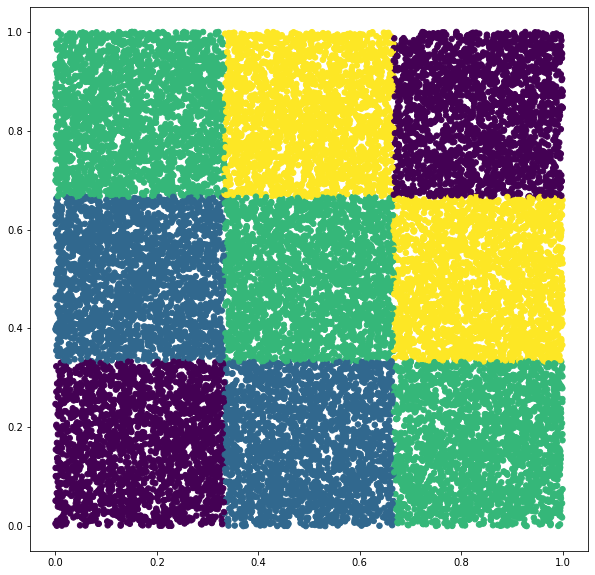

In [22]:
print(f"Number of points: {features.shape[0]}")
print(f"Number of classes: {len(np.unique(labels))}\n")
print("First 5 points coordinates")
print(features[:5, :])
print("\nFirst 5 labels")
print(labels[:5])
print("\nIf we display the points in a 2D plane, where each color is a class:")
fig, axs = plt.subplots(figsize=(10, 10))
plt.scatter(features[:, 0], features[:, 1], c=labels, s=30)
plt.show()

We easily see a mapping between the point coordinates.

<a id="subsection-training2"></a>
### Training

We are going to train a neural network to determine the class of a point based on its coordinates.

In [23]:
train_dataset = TensorDataset(torch.FloatTensor(features[:5000, :]), torch.LongTensor(labels[:5000]))
validation_dataset = TensorDataset(torch.FloatTensor(features[5000:, :]), torch.LongTensor(labels[5000:]))

model = NNNetwork(in_features=2, out_classes=4)

loss = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9, 
                      weight_decay=0.0005)

In [24]:
epochs = 30
batch_size = 512
history_loss, history_val_loss, history_accuracy, history_val_accuracy = train(train_dataset, validation_dataset, model, loss, optimizer, epochs, batch_size)


epoch: 1


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


train loss   0.0025515981674194338         val loss  0.002254703028996786          
train acc    41.460%                       val acc   59.740%                       
epoch: 2


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


train loss   0.002092991304397583          val loss  0.0018699540932973226         
train acc    59.740%                       val acc   61.433%                       
epoch: 3


100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


train loss   0.0016775322675704953         val loss  0.001428351163864136          
train acc    65.640%                       val acc   66.960%                       
epoch: 4


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


train loss   0.0012657670617103576         val loss  0.0010492913246154783         
train acc    77.160%                       val acc   85.213%                       
epoch: 5


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


train loss   0.0010022744476795196         val loss  0.0008713686287403108         
train acc    82.180%                       val acc   85.167%                       
epoch: 6


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


train loss   0.0008477172493934632         val loss  0.0007747950971126556         
train acc    83.880%                       val acc   84.980%                       
epoch: 7


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


train loss   0.0007756229877471923         val loss  0.0007300036152203878         
train acc    84.340%                       val acc   85.420%                       
epoch: 8


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


train loss   0.0007532410621643066         val loss  0.0006992098927497864         
train acc    84.540%                       val acc   85.747%                       
epoch: 9


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


train loss   0.000708088344335556          val loss  0.0007023670295874277         
train acc    85.060%                       val acc   84.907%                       
epoch: 10


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


train loss   0.0006973172008991241         val loss  0.0006892603735129039         
train acc    85.480%                       val acc   85.320%                       
epoch: 11


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


train loss   0.0006910550594329834         val loss  0.0006671716471513113         
train acc    85.440%                       val acc   85.220%                       
epoch: 12


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


train loss   0.0006597476780414581         val loss  0.0006282691856225331         
train acc    86.160%                       val acc   86.873%                       
epoch: 13


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


train loss   0.000621366822719574          val loss  0.0005980499605337778         
train acc    87.180%                       val acc   87.693%                       
epoch: 14


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


train loss   0.0006089402139186859         val loss  0.0005731882909933727         
train acc    87.300%                       val acc   88.540%                       
epoch: 15


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


train loss   0.0005919479489326477         val loss  0.0005558893909056982         
train acc    87.660%                       val acc   89.320%                       
epoch: 16


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


train loss   0.0005805744946002961         val loss  0.0005345523178577424         
train acc    88.080%                       val acc   89.620%                       
epoch: 17


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


train loss   0.0005607718050479889         val loss  0.0005252981960773466         
train acc    88.160%                       val acc   89.580%                       
epoch: 18


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


train loss   0.0005374494343996048         val loss  0.000513290191690127          
train acc    89.080%                       val acc   90.067%                       
epoch: 19


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


train loss   0.0005250342845916748         val loss  0.0005132305522759756         
train acc    89.400%                       val acc   89.827%                       
epoch: 20


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


train loss   0.000511940774321556          val loss  0.0004717875470717748         
train acc    89.980%                       val acc   91.213%                       
epoch: 21


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


train loss   0.0005129976749420166         val loss  0.0005390207062164943         
train acc    89.560%                       val acc   88.073%                       
epoch: 22


100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


train loss   0.0005139400869607926         val loss  0.0004536524186531702         
train acc    89.800%                       val acc   91.407%                       
epoch: 23


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


train loss   0.0004968258798122406         val loss  0.00045791021982828785        
train acc    89.260%                       val acc   90.800%                       
epoch: 24


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


train loss   0.00047732775211334236        val loss  0.00046358733673890424        
train acc    90.400%                       val acc   91.427%                       
epoch: 25


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


train loss   0.00044490969181060794        val loss  0.0004027306924263636         
train acc    91.560%                       val acc   93.093%                       
epoch: 26


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


train loss   0.0004225259363651275         val loss  0.00040304534832636513        
train acc    92.240%                       val acc   93.267%                       
epoch: 27


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


train loss   0.00042068376541137695        val loss  0.00044191625515619916        
train acc    92.120%                       val acc   91.347%                       
epoch: 28


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


train loss   0.00043767702877521515        val loss  0.000409186973174413          
train acc    91.180%                       val acc   91.373%                       
epoch: 29


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


train loss   0.0004196449875831604         val loss  0.0004115479608376821         
train acc    91.600%                       val acc   92.027%                       
epoch: 30


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


train loss   0.00040541907250881185        val loss  0.00035937856237093616        
train acc    92.160%                       val acc   94.020%                       


<a id="subsection-metrics2"></a>
### Metrics

Once again, the last step is to get the metrics from our training.
We can also see the predicted output.

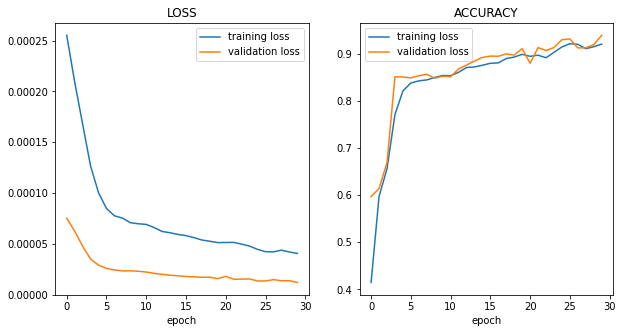

If we display the prediction on the validation set, where each color is a class:


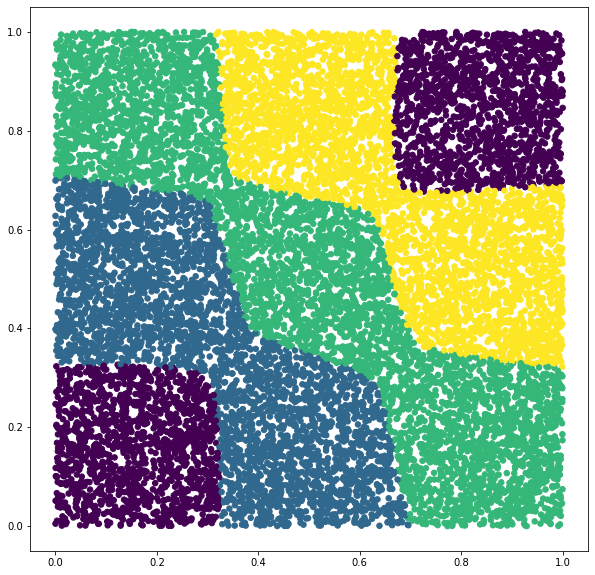

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(history_loss, label="training loss")
axs[0].plot(history_val_loss, label="validation loss")
axs[0].legend()
axs[0].set_title("LOSS")
axs[0].set_xlabel("epoch")

axs[1].plot(history_accuracy, label="training loss")
axs[1].plot(history_val_accuracy, label="validation loss")
axs[1].legend()
axs[1].set_title("ACCURACY")
axs[1].set_xlabel("epoch")
plt.show()

print("If we display the prediction on the validation set, where each color is a class:")
fig, axs = plt.subplots(figsize=(10, 10))
prediction = model(torch.FloatTensor(features[5000:, :])).detach().numpy()
plt.scatter(features[5000:, 0], features[5000:, 1], c=np.argmax(prediction, axis=1), s=30)
plt.show()